### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 09.01.2025 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
%load_ext autoreload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
os.chdir('/content/drive/My Drive/LR7')

In [4]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [24]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.68 s
Train ROC-AUC 0.9851
Valid ROC-AUC 0.9471
Test ROC-AUC 0.9452


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

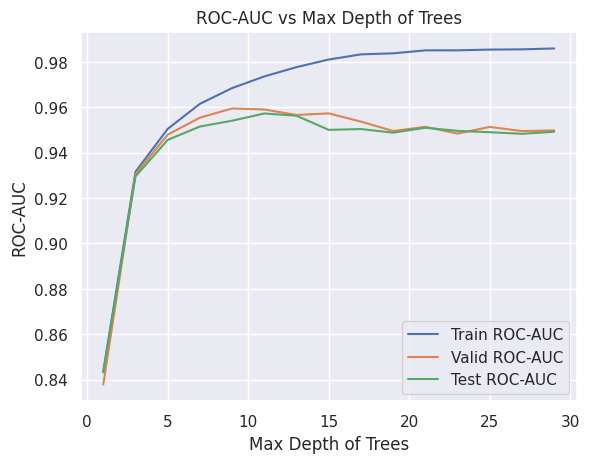

In [26]:
results = {}

depths = range(1, 30, 2)

### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

for depth in depths:
    # Инициализация модели с заданной глубиной деревьев
    boosting = Boosting(base_model_params={'max_depth': depth})

    # Обучаем модель
    boosting.fit(x_train, y_train, x_valid, y_valid)

    # Используем метод score для вычисления ROC-AUC на разных выборках
    train_auc = boosting.score(x_train, y_train)
    valid_auc = boosting.score(x_valid, y_valid)
    test_auc = boosting.score(x_test, y_test)

    # Сохраняем результаты
    results[depth] = {'train_auc': train_auc, 'valid_auc': valid_auc, 'test_auc': test_auc}

# Построение графика зависимости качества от максимальной глубины деревьев
depths_list = list(results.keys())
train_aucs = [results[depth]['train_auc'] for depth in depths_list]
valid_aucs = [results[depth]['valid_auc'] for depth in depths_list]
test_aucs = [results[depth]['test_auc'] for depth in depths_list]

# График ROC-AUC
plt.plot(depths_list, train_aucs, label='Train ROC-AUC')
plt.plot(depths_list, valid_aucs, label='Valid ROC-AUC')
plt.plot(depths_list, test_aucs, label='Test ROC-AUC')
plt.xlabel('Max Depth of Trees')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs Max Depth of Trees')
plt.legend()
plt.grid(True)
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Из графика видно, что наилучшее качество на валидационной и тестовой выборках достигается при умеренной глубине деревьев (примерно 5–15). После этого на тренировочной выборке качество продолжает улучшаться (переобучение), но на тестовой и валидационной выборках ROC-AUC остается на плато или даже немного снижается.

Это можно обьяснить тем, что при малой глубине деревьев (1–3) модель слишком проста и недостаточно обучается, поэтому ROC-AUC на всех выборках низкий, а слишком глубокие деревья начинают "запоминать" данные вместо того, чтобы учиться их обобщать.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [28]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [30]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
import optuna

# Целевая функция для Optuna
def objective(trial):
    # Гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Инициализация модели бустинга с текущими гиперпараметрами
    boosting = Boosting(
        base_model_params={
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
        },
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample
    )

    # Обучение модели
    boosting.fit(x_train, y_train, x_valid, y_valid)

    # Оценка на валидационной выборке
    valid_score = boosting.score(x_valid, y_valid)

    # Optuna стремится максимизировать целевую функцию (ROC-AUC)
    return valid_score

# Настройка и запуск Optuna
study = optuna.create_study(direction='maximize')  # Оптимизируем ROC-AUC (максимизация)
study.optimize(objective, n_trials=10)  # Запускаем 10 итераций, а то очень долго считает

# Параметры лучшей модели
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение и оценка лучшей модели
boosting_best = Boosting(
    base_model_params={
        'max_depth': best_params['max_depth'],
        'min_samples_split': best_params['min_samples_split'],
    },
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample']
)
boosting_best.fit(x_train, y_train, x_valid, y_valid)
train_score = boosting_best.score(x_train, y_train)
valid_score = boosting_best.score(x_valid, y_valid)
test_score = boosting_best.score(x_test, y_test)

print(f"Train ROC-AUC: {train_score:.4f}")
print(f"Valid ROC-AUC: {valid_score:.4f}")
print(f"Test ROC-AUC: {test_score:.4f}")


[I 2025-01-15 08:50:45,790] A new study created in memory with name: no-name-93feca36-5f60-4686-b385-27640902cc8b
[I 2025-01-15 08:51:17,690] Trial 0 finished with value: 0.961179552291731 and parameters: {'n_estimators': 98, 'learning_rate': 0.040559661508632036, 'subsample': 0.9420310112970325, 'max_depth': 15, 'min_samples_split': 6}. Best is trial 0 with value: 0.961179552291731.
[I 2025-01-15 08:51:24,746] Trial 1 finished with value: 0.9592387968078575 and parameters: {'n_estimators': 36, 'learning_rate': 0.03755165672455887, 'subsample': 0.5395958878832017, 'max_depth': 23, 'min_samples_split': 7}. Best is trial 0 with value: 0.961179552291731.
[I 2025-01-15 08:51:33,297] Trial 2 finished with value: 0.9587202452443866 and parameters: {'n_estimators': 45, 'learning_rate': 0.1353972669431204, 'subsample': 0.5707981105033648, 'max_depth': 8, 'min_samples_split': 8}. Best is trial 0 with value: 0.961179552291731.
[I 2025-01-15 08:51:45,806] Trial 3 finished with value: 0.9613255855

Лучшие параметры: {'n_estimators': 70, 'learning_rate': 0.08326301737629555, 'subsample': 0.7783540184736899, 'max_depth': 20, 'min_samples_split': 17}
Train ROC-AUC: 0.9887
Valid ROC-AUC: 0.9611
Test ROC-AUC: 0.9599


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

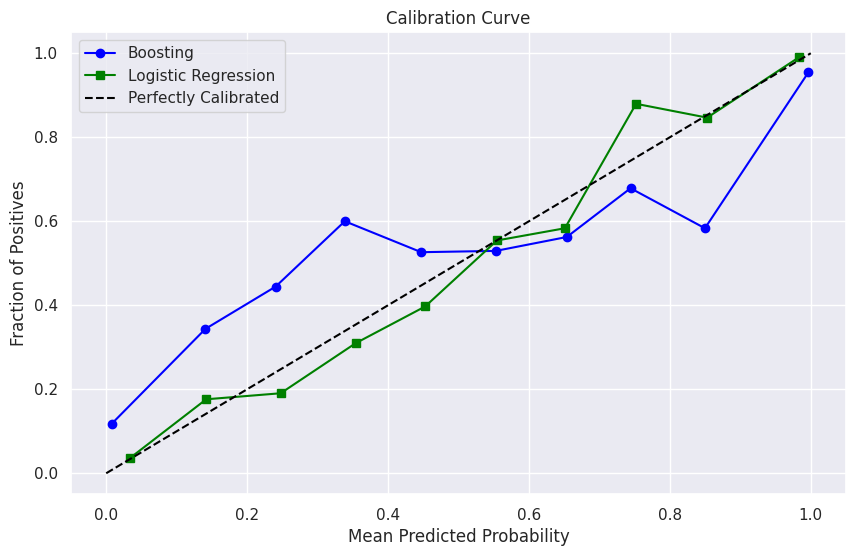

In [31]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Калибровочная кривая для лучшей модели градиентного бустинга
boosting_best.fit(x_train, y_train, x_valid, y_valid)
probs_boosting = boosting_best.predict_proba(x_test)[:, 1]  # Предсказания вероятностей для класса 1

# Калибровочная кривая для логистической регрессии
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
probs_logreg = logreg.predict_proba(x_test)[:, 1]  # Предсказания вероятностей для класса 1

# Вычисление калибровочной кривой
fraction_of_positives_boosting, mean_predicted_value_boosting = calibration_curve(y_test, probs_boosting, n_bins=10, strategy='uniform')
fraction_of_positives_logreg, mean_predicted_value_logreg = calibration_curve(y_test, probs_logreg, n_bins=10, strategy='uniform')

# Построение графика
plt.figure(figsize=(10, 6))

# Калибровочная кривая для градиентного бустинга
plt.plot(mean_predicted_value_boosting, fraction_of_positives_boosting, label='Boosting', marker='o', color='blue')

# Калибровочная кривая для логистической регрессии
plt.plot(mean_predicted_value_logreg, fraction_of_positives_logreg, label='Logistic Regression', marker='s', color='green')

# Линия идеальной калибровки
plt.plot([0, 1], [0, 1], label='Perfectly Calibrated', linestyle='--', color='black')

# Оформление графика
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True)
plt.show()

Градиентный бустинг менее точно оценивает вероятности, отклоняясь от идеальной диагонали, особенно для высоких и низких вероятностей. Логистическая регрессия ближе к идеальной калибровке, показывает более стабильную оценку вероятностей. Получается, что бустинг лучше справляется с предсказанием сложных зависимостей, но требует дополнительной калибровки вероятностей.

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

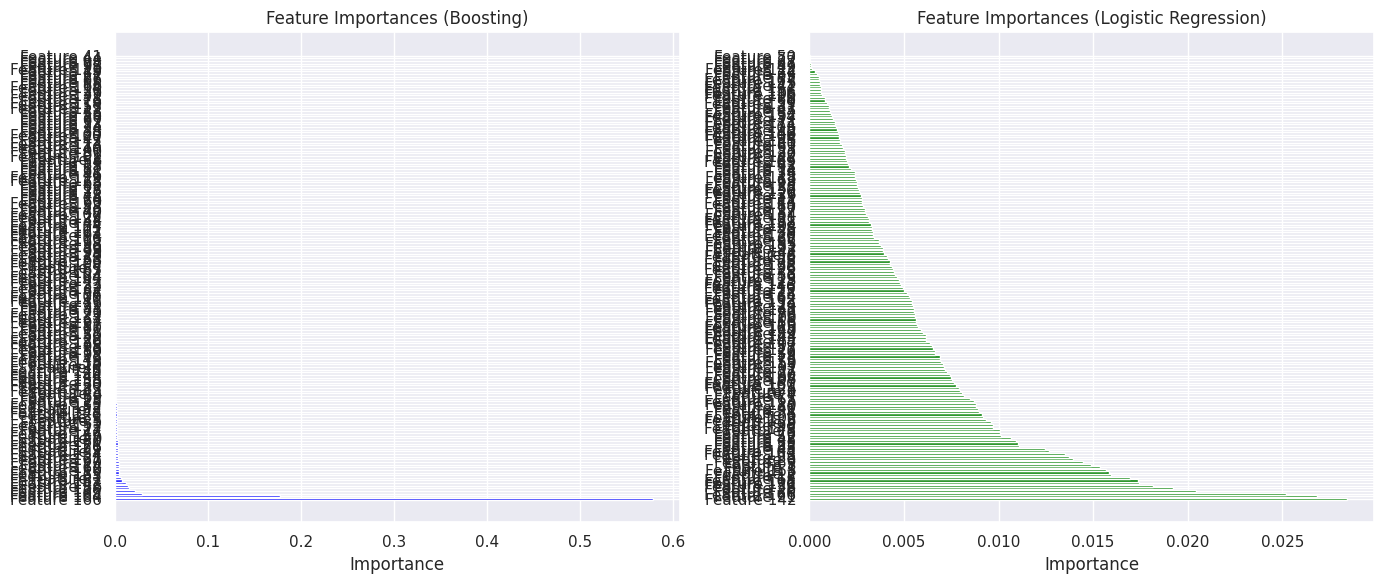

In [48]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
# Получаем важности признаков для градиентного бустинга
boosting_importances = boosting_best.feature_importances_

# Признаки для градиентного бустинга
features_boosting = np.argsort(boosting_importances)[::-1]
boosting_importances = boosting_importances[features_boosting]
boosting_features = [f"Feature {i}" for i in features_boosting]

# Признаки для логистической регрессии
features_logreg = np.argsort(logreg_importances)[::-1]
logreg_importances = logreg_importances[features_logreg]
logreg_features = [f"Feature {i}" for i in features_logreg]

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График для градиентного бустинга
axes[0].barh(boosting_features, boosting_importances, color='blue')
axes[0].set_title('Feature Importances (Boosting)')
axes[0].set_xlabel('Importance')

# График для логистической регрессии
axes[1].barh(logreg_features, logreg_importances, color='green')
axes[1].set_title('Feature Importances (Logistic Regression)')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

Сделаем топ-20 признаков для отображения.

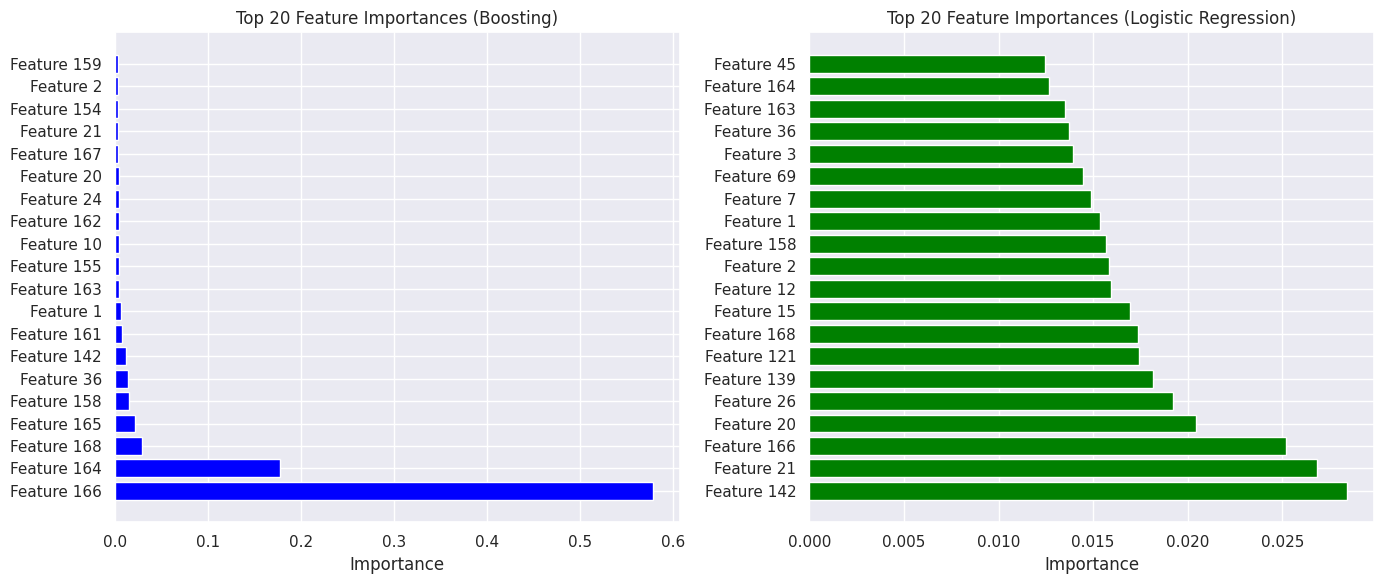

In [38]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
# Получаем важности признаков для градиентного бустинга
boosting_importances = boosting_best.feature_importances_

# Топ-20 признаков для градиентного бустинга
top_features_boosting = np.argsort(boosting_importances)[-20:][::-1]
boosting_top_importances = boosting_importances[top_features_boosting]
boosting_top_features = [f"Feature {i}" for i in top_features_boosting]

# Топ-20 признаков для логистической регрессии
top_features_logreg = np.argsort(logreg_importances)[-20:][::-1]
logreg_top_importances = logreg_importances[top_features_logreg]
logreg_top_features = [f"Feature {i}" for i in top_features_logreg]

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График для градиентного бустинга
axes[0].barh(boosting_top_features, boosting_top_importances, color='blue')
axes[0].set_title('Top 20 Feature Importances (Boosting)')
axes[0].set_xlabel('Importance')

# График для логистической регрессии
axes[1].barh(logreg_top_features, logreg_top_importances, color='green')
axes[1].set_title('Top 20 Feature Importances (Logistic Regression)')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()


Графики показывают, что градиентный бустинг выявляет небольшое число ключевых признаков с высокой важностью, игнорируя остальные. Логистическая регрессия распределяет важность более равномерно, так как работает линейно с признаками. Это указывает на способность бустинга лучше выявлять сложные зависимости, тогда как регрессия оценивает значимость признаков глобально.

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [47]:
# Получение важности признаков
boosting_importances = boosting_best.feature_importances_

# Ранжирование признаков по убыванию
sorted_indices = np.argsort(boosting_importances)[-30:][::-1]
sorted_importances = boosting_importances[sorted_indices]
sorted_features = [f"Feature {i}" for i in sorted_indices]

# Создание DataFrame для удобного отображения
import pandas as pd
feature_ranking = pd.DataFrame({
    "Feature": sorted_features,
    "Importance": sorted_importances
})

# Вывод полного ранжирования
print(feature_ranking)

        Feature  Importance
0   Feature 166    0.577816
1   Feature 164    0.177538
2   Feature 168    0.028882
3   Feature 165    0.021161
4   Feature 158    0.015480
5    Feature 36    0.013925
6   Feature 142    0.012141
7   Feature 161    0.007660
8     Feature 1    0.005998
9   Feature 163    0.004596
10  Feature 155    0.004261
11   Feature 10    0.004229
12  Feature 162    0.004146
13   Feature 24    0.003876
14   Feature 20    0.003807
15  Feature 167    0.003312
16   Feature 21    0.003204
17  Feature 154    0.003129
18    Feature 2    0.003077
19  Feature 159    0.003041
20  Feature 156    0.002895
21   Feature 71    0.002869
22  Feature 160    0.002676
23    Feature 0    0.002592
24  Feature 157    0.002419
25  Feature 146    0.002165
26   Feature 12    0.002025
27   Feature 27    0.001977
28  Feature 151    0.001910
29   Feature 35    0.001769


Используем диаграмму важности признаков, чтобы оставить только те признаки, важность которых выше определенного порога для градиентного бустинга

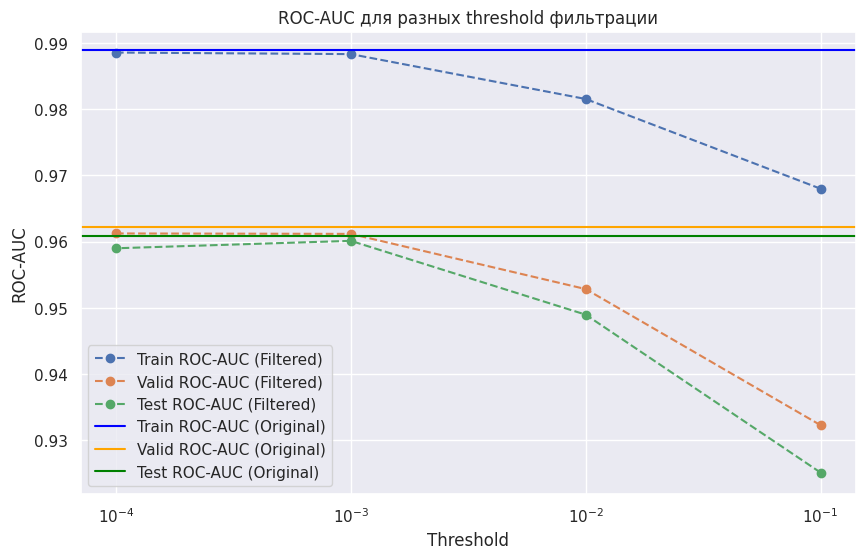

In [51]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

import matplotlib.pyplot as plt

# Параметры для перебора threshold
thresholds = [0.1, 0.01, 0.001, 0.0001]
results = {"threshold": [], "train_auc": [], "valid_auc": [], "test_auc": []}

# Исходные результаты
train_score_original = boosting_best.score(x_train, y_train)
valid_score_original = boosting_best.score(x_valid, y_valid)
test_score_original = boosting_best.score(x_test, y_test)

# Перебор threshold
for threshold in thresholds:
    # Отбор значимых признаков
    important_features = np.where(boosting_best.feature_importances_ > threshold)[0]

    # Оставляем только значимые признаки
    x_train_filtered = x_train[:, important_features]
    x_valid_filtered = x_valid[:, important_features]
    x_test_filtered = x_test[:, important_features]

    # Повторное обучение модели
    boosting_filtered = Boosting(
        base_model_params=boosting_best.base_model_params,
        n_estimators=boosting_best.n_estimators,
        learning_rate=boosting_best.learning_rate,
        subsample=boosting_best.subsample,
    )
    boosting_filtered.fit(x_train_filtered, y_train, x_valid_filtered, y_valid)

    # Оценка качества
    train_auc = boosting_filtered.score(x_train_filtered, y_train)
    valid_auc = boosting_filtered.score(x_valid_filtered, y_valid)
    test_auc = boosting_filtered.score(x_test_filtered, y_test)

    # Сохранение результатов
    results["threshold"].append(threshold)
    results["train_auc"].append(train_auc)
    results["valid_auc"].append(valid_auc)
    results["test_auc"].append(test_auc)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(results["threshold"], results["train_auc"], label="Train ROC-AUC (Filtered)", marker="o", linestyle="--")
plt.plot(results["threshold"], results["valid_auc"], label="Valid ROC-AUC (Filtered)", marker="o", linestyle="--")
plt.plot(results["threshold"], results["test_auc"], label="Test ROC-AUC (Filtered)", marker="o", linestyle="--")

# Добавляем исходные значения
plt.axhline(train_score_original, color="blue", linestyle="-", label="Train ROC-AUC (Original)")
plt.axhline(valid_score_original, color="orange", linestyle="-", label="Valid ROC-AUC (Original)")
plt.axhline(test_score_original, color="green", linestyle="-", label="Test ROC-AUC (Original)")

# Оформление графика
plt.xscale("log")  # Логарифмическая шкала для threshold
plt.xlabel("Threshold")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC для разных threshold фильтрации")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
results_df = pd.DataFrame({
    "Threshold": ["Original"] + results["threshold"],
    "Train ROC-AUC": [train_score_original] + results["train_auc"],
    "Valid ROC-AUC": [valid_score_original] + results["valid_auc"],
    "Test ROC-AUC": [test_score_original] + results["test_auc"]
})

results_df

,Threshold,Train ROC-AUC,Valid ROC-AUC,Test ROC-AUC
0,Original,0.988867,0.962143,0.960811
1,0.1,0.967969,0.932280,0.925125
2,0.01,0.981513,0.952822,0.948959
3,0.001,0.988287,0.961151,0.960101
4,0.0001,0.988522,0.961216,0.958978


График показывает, что фильтрация незначительных признаков не улучшила качество модели.

Исходная модель демонстрирует более высокие значения ROC-AUC на всех выборках, чем модели после фильтрации.
При увеличении значения threshold, качество существенно падает, особенно на тестовой выборке.

При малых значениях фильтра модель приближается к занчениям на исходной модели, в нашем случае приемлимым результатом будет примерно $10^{-3}$, вопрос, сколько там этих признаков остается. В принципе, $10^{-2}$ тоже относительно неплохо выглядит.

Видимо надо использовать чтото более сложное для фильтрации, а не просто жесткую фильтрацию признаков

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [62]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize

# Получение предсказаний
probs_boosting = boosting_best.predict_proba(x_test)[:, 1]  # Предсказания вероятностей бустинга
probs_logreg = logreg.predict_proba(x_test)[:, 1]  # Предсказания вероятностей логистической регрессии

# Целевая функция для оптимизации веса
def blending_loss(weights):
    # Комбинируем предсказания моделей
    blended_probs = weights[0] * probs_boosting + weights[1] * probs_logreg
    # Вычисляем метрику ROC-AUC
    return -roc_auc_score(y_test, blended_probs)  # Минимизируем отрицательный ROC-AUC

# Оптимизация весов
initial_weights = [0.5, 0.5]  # Стартовые веса
constraints = ({'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1})  # Сумма весов = 1
bounds = [(0, 1), (0, 1)]  # Каждый вес от 0 до 1

result = minimize(blending_loss, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x

# Финальные предсказания после блендинга
final_blended_probs = optimal_weights[0] * probs_boosting + optimal_weights[1] * probs_logreg

# Оценка качества
roc_auc_blended = roc_auc_score(y_test, final_blended_probs)
roc_auc_boosting = roc_auc_score(y_test, probs_boosting)
roc_auc_logreg = roc_auc_score(y_test, probs_logreg)

# Результаты
print(f"ROC-AUC (Boosting): {roc_auc_boosting:.4f}")
print(f"ROC-AUC (Logistic Regression): {roc_auc_logreg:.4f}")
print(f"ROC-AUC (Blended): {roc_auc_blended:.4f}")
print(f"Optimal weights: Boosting={optimal_weights[0]:.2f}, Logistic Regression={optimal_weights[1]:.2f}")

ROC-AUC (Boosting): 0.9608
ROC-AUC (Logistic Regression): 0.9623
ROC-AUC (Blended): 0.9643
Optimal weights: Boosting=0.50, Logistic Regression=0.50


Блендинг несколько улучшил ROC-AUC по сравнению с каждой моделью по отдельности.

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [64]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [65]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Инициализация CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,        # Количество итераций
    learning_rate=0.1,     # Темп обучения
    depth=6,               # Максимальная глубина деревьев
    loss_function='Logloss',  # Функция потерь
    eval_metric='AUC',     # Метрика для оценки
    verbose=False,         # Отключаем вывод
    random_seed=42
)

# Обучение CatBoost
catboost_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))

# Предсказания вероятностей
probs_catboost = catboost_model.predict_proba(x_test)[:, 1]

# Оценка ROC-AUC
roc_auc_catboost = roc_auc_score(y_test, probs_catboost)
roc_auc_boosting = boosting_best.score(x_test, y_test)

# Сравнение результатов
print(f"ROC-AUC (Boosting): {roc_auc_boosting:.4f}")
print(f"ROC-AUC (CatBoost): {roc_auc_catboost:.4f}")

ROC-AUC (Boosting): 0.9608
ROC-AUC (CatBoost): 0.9650


CatBoost также несколько улучшил показатель ROC-AUC. Возможно, наш набор данных довольно простой, поэтому прирост не такой значительный, но вероятно на сложных данных этот показатель приведет к существенному улучшению показателя

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
